In [1]:
from build_graphs import *

In [2]:
feature_names = ['x', 'y', 'z', 'cell_count', 'cell_val', 'leta', 'lphi', 'lx', 'ly', 'lz', 'geta', 'gphi']

In [3]:
artifact_storage_path = "/global/cfs/cdirs/m3443/usr/aoka/data/artifacts/Training_Example_0"
best_emb_path = os.path.join(artifact_storage_path, 'metric_learning_emb', 'best_model.pkl')
best_filter_path = os.path.join(artifact_storage_path, 'metric_learning_filter', 'best_model.pkl')    
    
emb_model = load_embed_model(best_emb_path, DEVICE).to(DEVICE)
filter_model = load_filter_model(best_filter_path, DEVICE).to(DEVICE)
emb_model.eval()
filter_model.eval()

Edge_MLP(
  (layers): ModuleList(
    (0): Linear(in_features=28, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (act1): ReLU()
  (final_layer): Linear(in_features=512, out_features=1, bias=True)
  (act2): Sigmoid()
)

# Embedding

In [5]:
def get_one_emb_eff_purity(index, hits, truth, emb_neighbors):
    vol = hits[['volume_id', 'layer_id']].values.T
    hit = hits.iloc[index]
    pid = truth.iloc[index]['particle_id']
    
    # get true neighbors based on particle id
    if pid == 0:
        true_neighbors = []
    else:
        hit_idx = truth[truth['particle_id']==pid]['hit_id']
        true_hits = hits[hits['hit_id'].isin(hit_idx) & (hits['hit_id'] != hit['hit_id'])]
        true_neighbors = true_hits.index.values.astype(int)
        #true_neighbors = filter_one_neighborhood(hit['volume_id'], hit['layer_id'], neighbors, vol[0], vol[1])
    
    #emb_neighbors = filter_one_neighborhood(hit['volume_id'], hit['layer_id'], emb_neighbors[index], vol[0], vol[1])
    emb_neighbors = emb_neighbors[index]
    
    # calculate purity and eff
    n_true_neighbors = sum(map(lambda n : n in true_neighbors, emb_neighbors))
    purity = n_true_neighbors / len(emb_neighbors) if len(emb_neighbors) > 0 else None
    efficiency = n_true_neighbors / len(true_neighbors) if len(true_neighbors) > 0 else None
    return purity, efficiency

In [6]:
def get_emb_eff_purity(hits, truth, emb_neighbors):
    n_iter = len(hits)
    purity = []
    efficiency = []

    for i in range(n_iter):
        p, eff = get_one_emb_eff_purity(i, hits, truth, emb_neighbors)
        if p: purity.append(p)
        if eff: efficiency.append(eff)
        if i % (n_iter//10) == 0:
            print(int((i+1) / (n_iter//100)),"% done")

    return purity, efficiency

In [7]:
event_name = "event000001000.pickle"
data_path = f"/global/cfs/cdirs/m3443/usr/aoka/data/classify/Classify_Example_0.4/preprocess_raw"
hits, truth = load_event(data_path, event_name)
print("number of hits:", len(hits))

neighbors = get_emb_neighbors(hits[feature_names].values, emb_model, 0.4)

emb_purity, emb_efficiency = get_emb_eff_purity(hits, truth, neighbors)

number of hits: 57692
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done


In [8]:
sum(emb_purity)/len(emb_purity)

0.012039429232400032

In [9]:
sum(emb_efficiency)/len(emb_efficiency)

0.8470182010966506

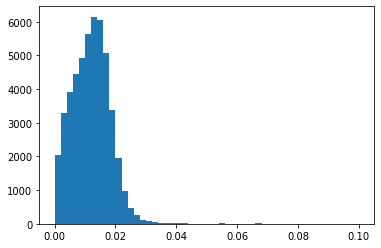

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(emb_purity, 50, range=(0, 0.1))
plt.show()

# Filtering

In [12]:
def get_filter_eff_purity(hits, truth, neighbors):
    vol = hits[['volume_id', 'layer_id']].values.T

    batch_size = 64
    num_workers = 12 if DEVICE=='cuda' else 0
    dataset = EdgeData(hits[feature_names].values, vol, neighbors)
    loader = DataLoader(dataset,
                        batch_size = batch_size,
                        num_workers = num_workers,
                        collate_fn = my_collate)
    # apply filter model
    idx_pairs, scores = predict_pairs(loader, filter_model, batch_size)
    
    # get true pairs
    true_pairs = []
    truth_np = np.matrix(truth.values)

    with torch.autograd.no_grad():
        for i, pair in enumerate(idx_pairs):
            hit_a = truth_np[pair[0], 1]
            hit_b = truth_np[pair[1], 1]
            if hit_a != 0 and hit_a == hit_b: #compare particle id
                true_pairs.append((pair[0], pair[1]))
            if i % (len(idx_pairs)//10) == 0:
                print(int((i+1) / (len(idx_pairs)//100)),"% done")
                
    # get filtered pairs
    filter_pairs, _ = apply_filter(idx_pairs, scores, 0.95)
    filter_pairs = [(pair[0], pair[1]) for pair in filter_pairs]
    
    # calculate efficiency and purity
    true_pairs_set = frozenset(true_pairs)
    n_true_pairs = sum(map(lambda n : n in true_pairs_set, filter_pairs))
    purity = n_true_pairs / len(filter_pairs)
    efficiency = n_true_pairs / len(true_pairs)
    return purity, efficiency

event: 0 number of hits: 52482
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
emb result: 0.013184823918442428 0.8470182010966506
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
filter result: 0.06074889486156405 0.7385275274188294
event: 0.2 number of hits: 55059
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
emb result: 0.012583616234639968 0.8470182010966506
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
filter result

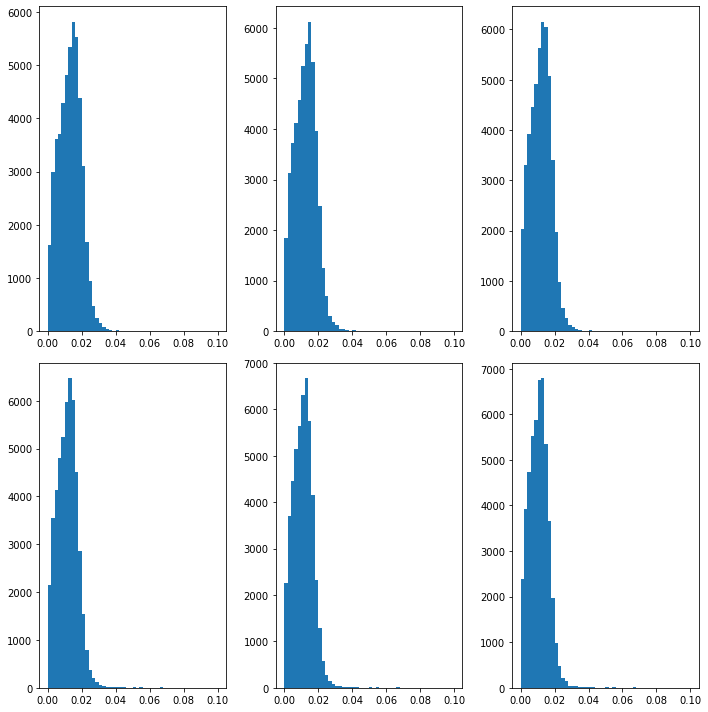

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

noise_keeps = ["0", "0.2", "0.4", "0.6", "0.8", "1"]
emb_ps = []
emb_efs = []
filter_ps = []
filter_efs = []

fig, axes = plt.subplots(2, 3, figsize=(10,10))

for i, noise_keep in enumerate(noise_keeps):
    event_name = "event000001000.pickle"
    data_path = f"/global/cfs/cdirs/m3443/usr/aoka/data/classify/Classify_Example_{noise_keep}/preprocess_raw"
    hits, truth = load_event(data_path, event_name)
    print("event:", noise_keep, "number of hits:", len(hits))
    
    neighbors = get_emb_neighbors(hits[feature_names].values, emb_model, 0.4)
    
    emb_purity, emb_efficiency = get_emb_eff_purity(hits, truth, neighbors)
    axes[i//3][i%3].hist(emb_purity, 50, range=(0, 0.1))
    emb_purity = sum(emb_purity)/len(emb_purity)
    emb_efficiency = sum(emb_efficiency)/len(emb_efficiency)
    print("emb result:", emb_purity, emb_efficiency)
    emb_ps.append(emb_purity)
    emb_efs.append(emb_efficiency)
    
    filter_purity, filter_efficiency = get_filter_eff_purity(hits, truth, neighbors)
    print("filter result:", filter_purity, filter_efficiency)
    filter_ps.append(filter_purity)
    filter_efs.append(filter_efficiency)
    
plt.tight_layout()

In [14]:
filter_efs

[0.7385275274188294,
 0.7385223472179994,
 0.7385298684939242,
 0.7385733056783259,
 0.7385246880734941,
 0.7385515870861251]

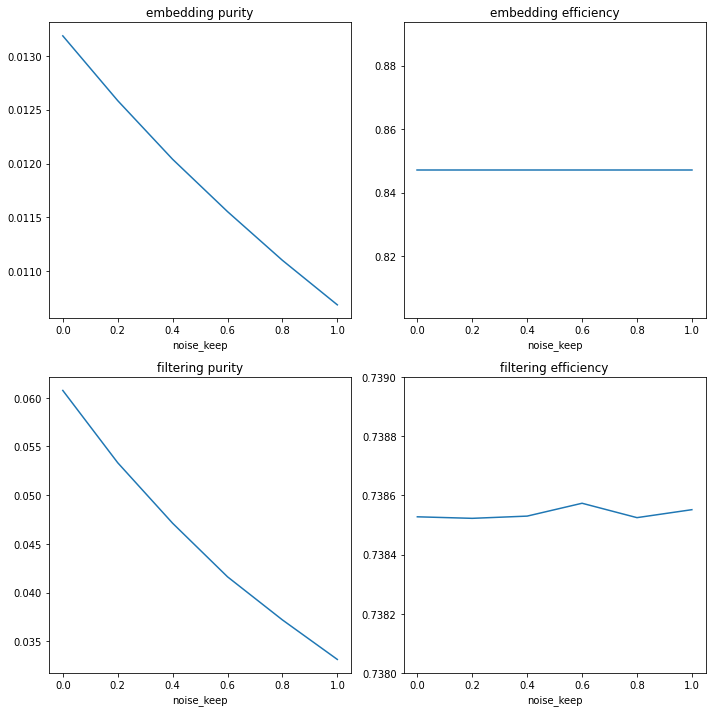

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
x = [float(keep) for keep in noise_keeps]
ax1.plot(x, emb_ps)
ax1.set_title("embedding purity")
ax1.set_xlabel("noise_keep")
ax2.plot(x, emb_efs)
ax2.set_title("embedding efficiency")
ax2.set_xlabel("noise_keep")

ax3.plot(x, filter_ps)
ax3.set_title("filtering purity")
ax3.set_xlabel("noise_keep")
ax4.plot(x, filter_efs)
ax4.set_ylim(0.738, 0.739)
ax4.set_title("filtering efficiency")
ax4.set_xlabel("noise_keep")

plt.tight_layout()